# Caderno 6(b) - Calcula métricas considerando os resultados de pesquisa em um BM25 com expansão de documentos com doc2query (considera apenas uma query)

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_ENUNCIADO_EXCERTO_DOC2QUEY = False

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/6_metricas_bm25_com_doc2query/'
NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto_e_doc2query_apenas_uma_query.pickle'

## 1. Carrega base de dados

Carrega a lista de documentos para indexar, as queries para testar e o qrels.

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

Carrega a expansão das queries gerada no caderno anterior:

In [3]:
import pickle

PASTA_CADERNO_DOC2QUERY = f'{PASTA_DADOS}outputs/5_doc2query/'
NOME_ARQUIVO_DOC2QUERY = f'{PASTA_CADERNO_DOC2QUERY}doc2query.pickle'

# Fazemos o caminho inverso aqui:
with open(NOME_ARQUIVO_DOC2QUERY, 'rb') as f:
    queries_por_doc = pickle.load(f)

Insere a informação do doc2query no dataframe de documentos. Se o doc2query tiver gerado queries idênticas, desconsidera as duplicadas:

In [4]:
docs['DOC2QUERY'] = docs['KEY'].map(lambda key: queries_por_doc[key][0] )

## 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO e as queries expandidas

In [5]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt_remove_html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [6]:
import os

# Vamos criar um índice invertido e indexar o enunciado, excerto e as queries geradas com o doc2query
iidx = IndiceInvertido(tokenizador_pt_remove_html)

if REINDEXAR_ENUNCIADO_EXCERTO_DOC2QUEY or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY):
    # Se for indexar a primeira vez:
    # Demora cerca de XX minutos para indexar
    iidx.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO'] + ' ' + row['DOC2QUERY']))
    iidx.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY)
else:
    # Se quiser recuperar de um arquivo:
    iidx.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY)

In [7]:
print(iidx.get_tamanho_medio_docs())

480.5619196011219


In [8]:
# Agora instancia um BM25
buscador = BM25(iidx, k1=0.82, b=0.68, bias_idf=1)

## 3. Faz as pesquisas e salva os resultados

In [9]:
col_resultado_query_key=[]
col_resultado_doc_key=[]
col_resultado_rank=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    resultados = buscador.pesquisar(query_text)

    primeiros_50_docs = [tupla_key_score[0] for tupla_key_score in resultados[:50]]
    queries_keys = [query_key] * len(primeiros_50_docs)
    ranking = list(range(1, len(primeiros_50_docs)+1))

    col_resultado_query_key.extend(queries_keys)
    col_resultado_doc_key.extend(primeiros_50_docs)
    col_resultado_rank.extend(ranking)

df_resultados = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key,
    "DOC_KEY": col_resultado_doc_key,
    "RANK": col_resultado_rank,
})

In [10]:
from metricas import metricas

df_metricas = metricas(df_resultados, qrels, aproximacao_trec_eval=True)

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.284000,0.268000,0.224000,0.128000,0.114853,0.220925,0.370759,0.522587,0.535333,0.554913,0.562029,0.563163,0.302668,0.305756,0.378664,0.453929
std,14.57738,0.255838,0.194244,0.125454,0.051587,0.100655,0.168021,0.225613,0.236929,0.431848,0.409393,0.400028,0.398440,0.264394,0.233368,0.233769,0.222586
min,1.00000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.000000,0.033273
25%,13.25000,0.000000,0.100000,0.112500,0.100000,0.000000,0.072802,0.178571,0.333333,0.000000,0.166667,0.166667,0.166667,0.000000,0.087672,0.175248,0.282780
50%,25.50000,0.200000,0.250000,0.225000,0.120000,0.083333,0.200000,0.374126,0.519231,0.500000,0.500000,0.500000,0.500000,0.299141,0.301532,0.370734,0.479339
75%,37.75000,0.400000,0.400000,0.300000,0.175000,0.195455,0.351190,0.461538,0.714286,1.000000,1.000000,1.000000,1.000000,0.470365,0.501462,0.570225,0.639971
max,50.00000,1.000000,0.700000,0.500000,0.200000,0.384615,0.571429,0.818182,0.909091,1.000000,1.000000,1.000000,1.000000,0.991365,0.835110,0.834720,0.834720


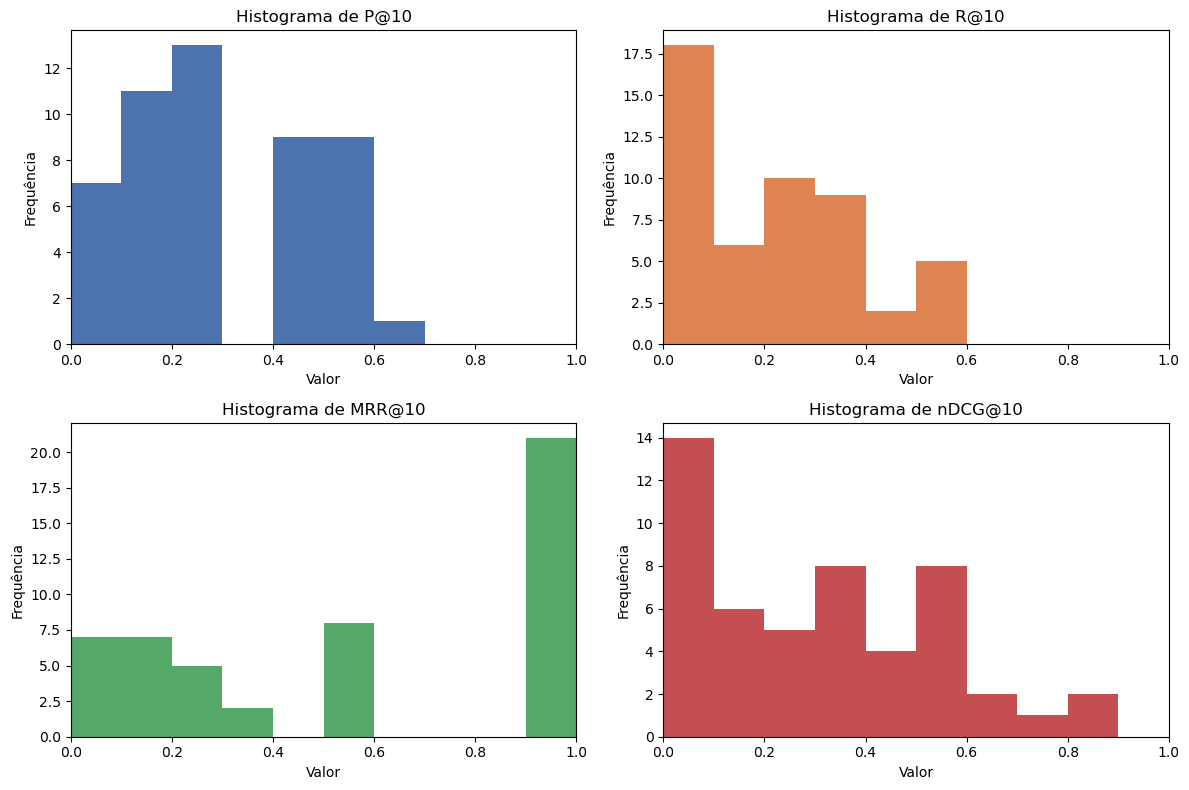

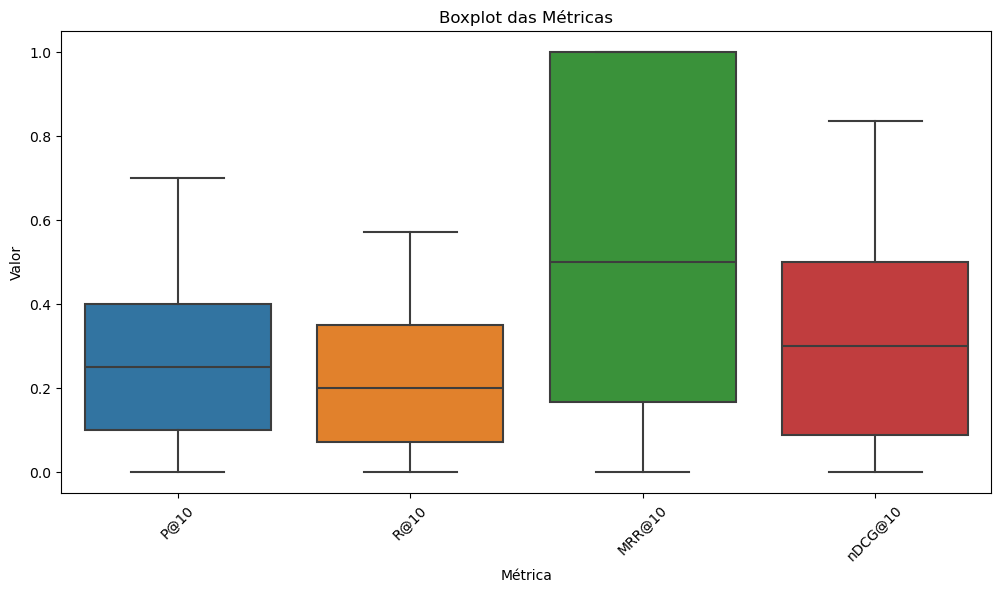

In [11]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries:
display(df_metricas[0:50].describe())
histograma_metricas(df_metricas[0:50])
boxplot_metricas(df_metricas[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.508000,0.378000,0.264000,0.141200,0.213552,0.318153,0.442048,0.588331,0.890000,0.896944,0.896944,0.896944,0.590930,0.524707,0.567515,0.631767
std,14.57738,0.259387,0.195135,0.128983,0.049555,0.113627,0.177213,0.232090,0.223230,0.286428,0.264955,0.264955,0.264955,0.237630,0.189768,0.197955,0.178791
min,51.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.071429,0.076923,0.083333,0.000000,0.111111,0.111111,0.111111,0.000000,0.051685,0.119588,0.127326
25%,63.25000,0.400000,0.225000,0.150000,0.105000,0.145604,0.230769,0.275974,0.436813,1.000000,1.000000,1.000000,1.000000,0.481475,0.411815,0.437079,0.552963
50%,75.50000,0.500000,0.400000,0.250000,0.160000,0.218254,0.285714,0.422619,0.607692,1.000000,1.000000,1.000000,1.000000,0.645588,0.561781,0.592790,0.651515
75%,87.75000,0.800000,0.500000,0.350000,0.180000,0.305769,0.425595,0.583333,0.750000,1.000000,1.000000,1.000000,1.000000,0.747152,0.652232,0.678521,0.735204
max,100.00000,1.000000,0.700000,0.500000,0.200000,0.454545,0.700000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.836926,0.916412,0.945686


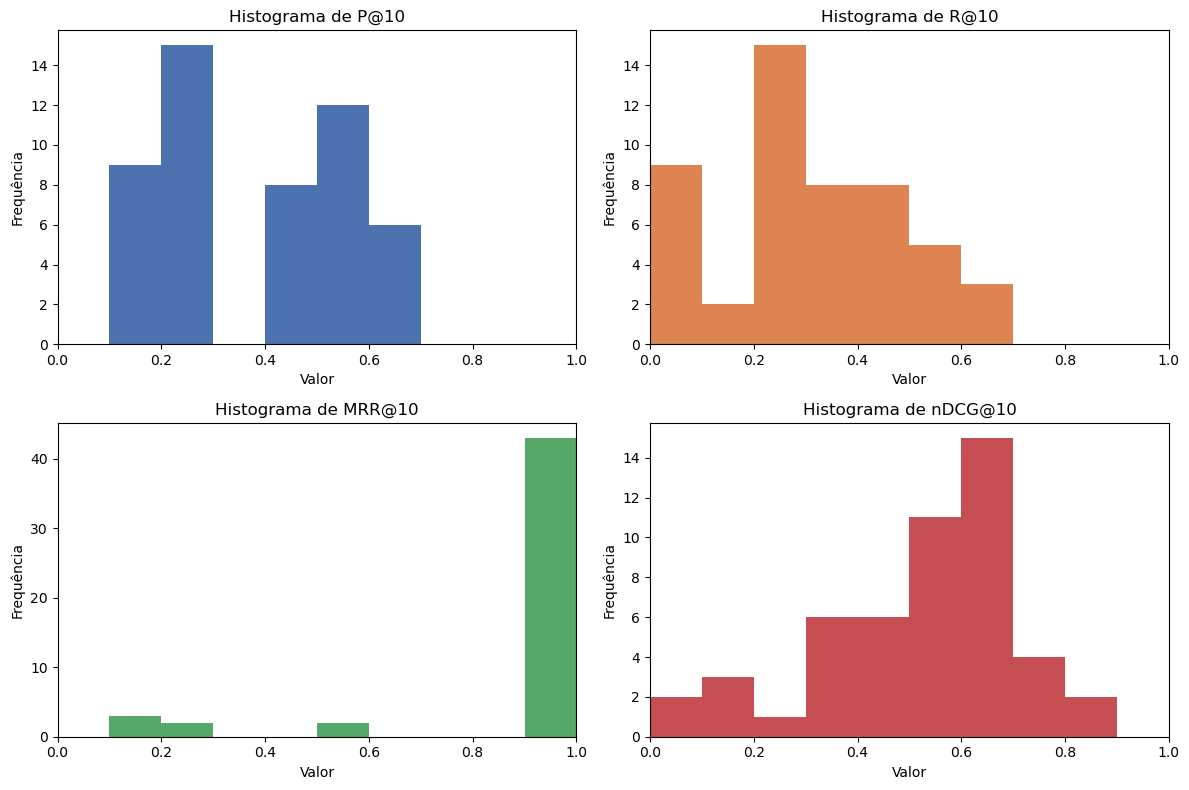

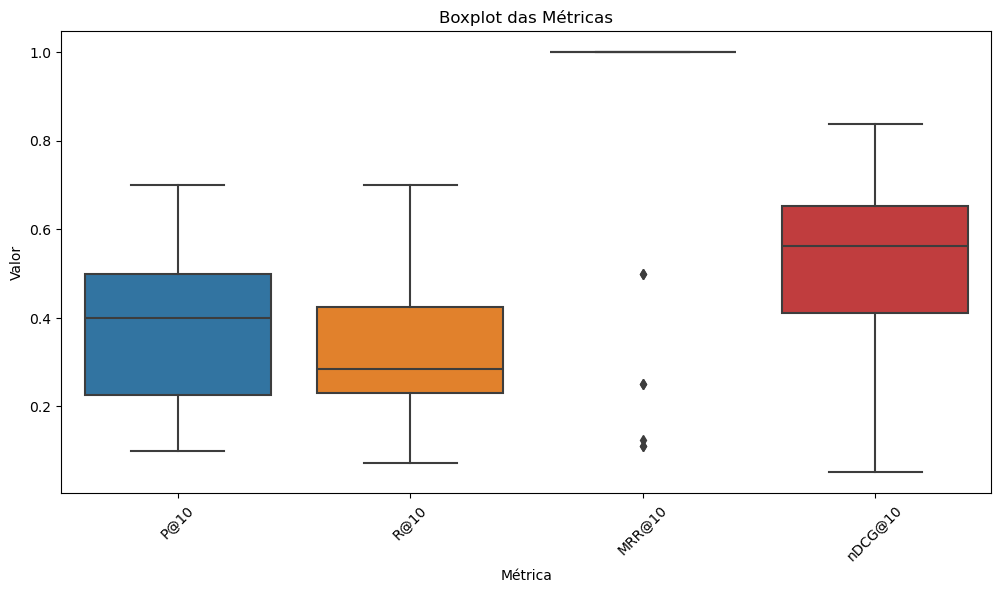

In [12]:
# Resultados para o segundo grupo de queries:
display(df_metricas[50:100].describe())
histograma_metricas(df_metricas[50:100])
boxplot_metricas(df_metricas[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.508000,0.380000,0.264000,0.136800,0.227420,0.338283,0.466921,0.602589,0.926667,0.928889,0.928889,0.928889,0.600009,0.529103,0.583882,0.637714
std,14.57738,0.239762,0.192725,0.125779,0.052739,0.114922,0.171516,0.222408,0.231071,0.210711,0.201106,0.201106,0.201106,0.205154,0.178124,0.182105,0.168315
min,101.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.066667,0.071429,0.100000,0.000000,0.111111,0.111111,0.111111,0.000000,0.070969,0.247781,0.269553
25%,113.25000,0.400000,0.200000,0.200000,0.105000,0.166667,0.207692,0.307692,0.461538,1.000000,1.000000,1.000000,1.000000,0.471887,0.434211,0.453530,0.489836
50%,125.50000,0.600000,0.400000,0.250000,0.140000,0.218254,0.333333,0.480769,0.625874,1.000000,1.000000,1.000000,1.000000,0.620249,0.539274,0.609430,0.679416
75%,137.75000,0.600000,0.500000,0.350000,0.180000,0.300000,0.454545,0.595833,0.750000,1.000000,1.000000,1.000000,1.000000,0.720214,0.668142,0.728450,0.773469
max,150.00000,1.000000,0.800000,0.500000,0.220000,0.500000,0.727273,0.909091,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.877208,0.942564,0.942564


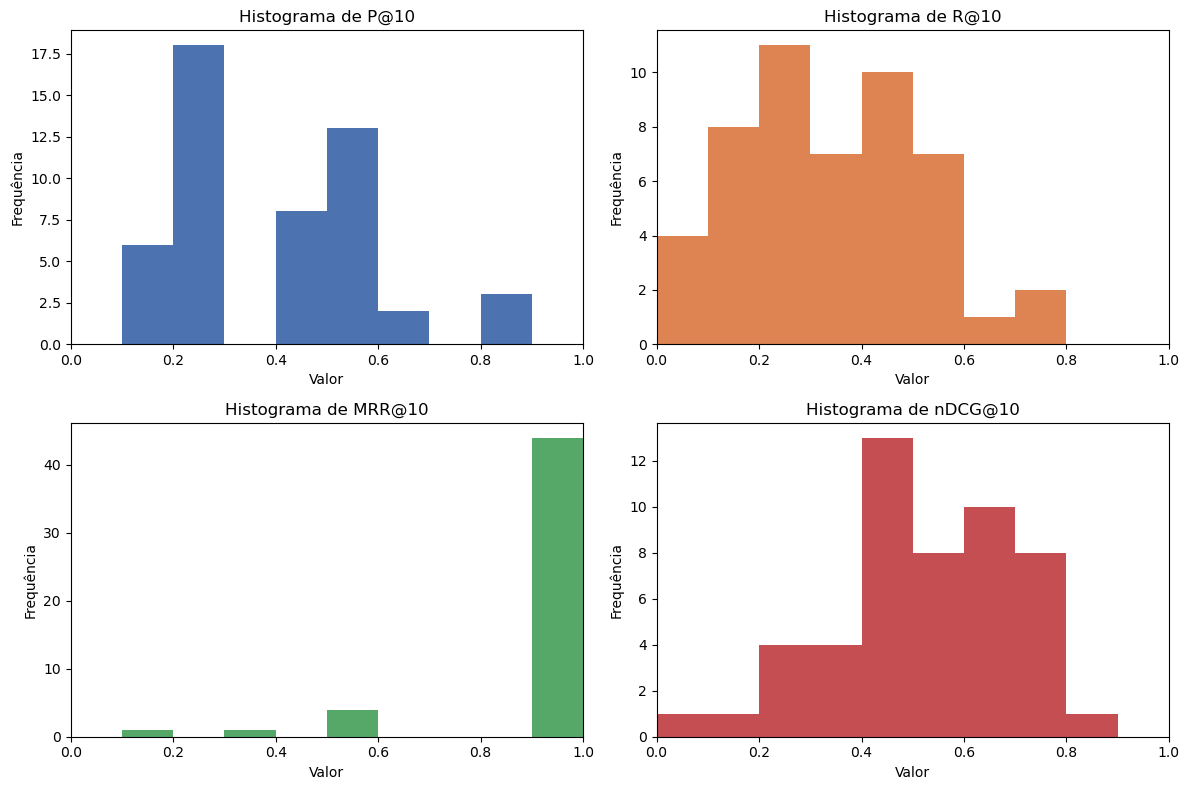

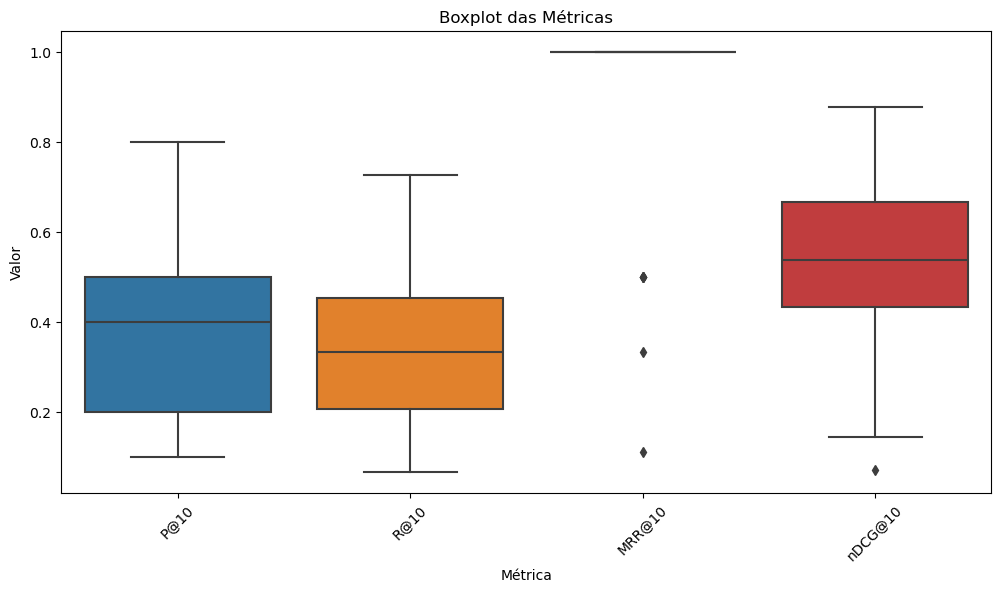

In [13]:
# Resultados para o terceiro grupo de queries:
display(df_metricas[100:150].describe())
histograma_metricas(df_metricas[100:150])
boxplot_metricas(df_metricas[100:150])